## **Fig.X: Candidates for first plot**

In [2]:
import sys
sys.path.append("..")
from utils import edgelist_c2c, create_network

import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy import text, inspect, MetaData

from tqdm import tqdm
import numpy as np
from pathlib import Path
import geopandas as gpd
import pandas as pd
import datetime as dt
from collections import defaultdict, Counter

from dateutil.relativedelta import relativedelta
from scipy.stats import linregress

import networkx as nx
from networkx.algorithms import bipartite

import nxviz as nv
from nxviz import layouts, plots, lines
from nxviz import nodes, edges, annotate, highlights
from nxviz.plots import despine, rescale, respine, aspect_equal
from nxviz.utils import edge_table, node_table
from nxviz import encodings as aes

from nxviz.utils import edge_table, node_table
from nxviz import encodings as aes

import matplotlib
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Tahoma"]

basepath = Path.home().joinpath("Documents", "data")
netpath = basepath.joinpath("regulacao", "edgelists_demanda3fev25")
geopath = basepath.joinpath("shapefilesceqgis")
netpath_ne = basepath.joinpath("regulacao", "edgelists", "nordeste_no_service")

mun_brasil_df = gpd.read_parquet(geopath.joinpath("BR_Municipios_2022", "municipios_brasil_poly_centroid.parquet"))
uf_brasil_df = gpd.read_file(geopath.joinpath("BR_UF_2022", "BR_UF_2022.dbf"))

# -- load geo
geodata_df = gpd.read_parquet(geopath.joinpath("ce_geodata.parquet"))
ce_geodata_df = gpd.read_parquet(geopath.joinpath("ce_regiao_saude_municipios.parquet"))

c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\nxviz\__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.4 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.4, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


In [3]:
# -- logarithm scaling of edge fluxes and node sizes.
def logrank(data : pd.Series, max_power_base10 : int, number_of_bins=12):
    logspace = np.logspace(0, max_power_base10, number_of_bins, base=10)
    return data.apply(lambda x: np.argmax(logspace > x)  ) # index of the first true

def summarize_network(G, return_summary=True):
    summary = {}

    # Basic information
    summary['Number of Nodes'] = G.number_of_nodes()
    summary['Number of Edges'] = G.number_of_edges()
    summary['Is Directed'] = G.is_directed()
    summary['Is Bipartite'] = bipartite.is_bipartite(G)

    # Node and edge metadata keys
    if len(G.nodes) > 0:
        summary['Node Metadata Keys'] = list(next(iter(G.nodes(data=True)))[1].keys())
    else:
        summary['Node Metadata Keys'] = []

    if len(G.edges) > 0:
        summary['Edge Metadata Keys'] = list(next(iter(G.edges(data=True)))[2].keys())
    else:
        summary['Edge Metadata Keys'] = []

    # Degree information
    if G.is_directed():
        in_degrees = dict(G.in_degree())
        out_degrees = dict(G.out_degree())
        try:
            summary['Mean In-Degree'] = sum(in_degrees.values()) / len(in_degrees)
        except: pass
        try:
            summary['Mean Out-Degree'] = sum(out_degrees.values()) / len(out_degrees)
        except: pass
    else:
        degrees = dict(G.degree())
        summary['Mean Degree'] = sum(degrees.values()) / len(degrees)

    # Printing summary
    for key, value in summary.items():
        print(f"{key}: {value}")

    if return_summary:
        return summary

## **Geolocation of municipalities**

In [4]:
mun_brasil_df["GEOCOD6"] = mun_brasil_df["CD_MUN"].apply(lambda x: x[:6])
mun_brasil_df['centroid'] = mun_brasil_df.centroid
mun_brasil_df["lat"] = mun_brasil_df['centroid'].y
mun_brasil_df["long"] = mun_brasil_df['centroid'].x
mun_brasil_df.sample(n=4)

C:\Users\Higor Monteiro\AppData\Local\Temp\ipykernel_15980\3846067986.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mun_brasil_df['centroid'] = mun_brasil_df.centroid


CD_MUN  AREA_KM2                                           geometry  \
1244  2500304   322.071  POLYGON ((-35.51901 -7.03058, -35.51865 -7.030...   
5147  5004809   416.605  POLYGON ((-54.56858 -23.87447, -54.57031 -23.8...   
4580  4218202   128.313  POLYGON ((-49.23246 -26.85174, -49.24256 -26.8...   
1662  2701308    94.357  POLYGON ((-36.13414 -9.40345, -36.13488 -9.405...   

     GEOCOD6                     centroid        lat       long  
1244  250030   POINT (-35.60284 -7.05907)  -7.059072 -35.602842  
5147  500480  POINT (-54.53807 -23.81077) -23.810766 -54.538069  
4580  421820  POINT (-49.26885 -26.80819) -26.808192 -49.268848  
1662  270130   POINT (-36.16022 -9.39330)  -9.393305 -36.160216

## connection to database

In [5]:
basepath = Path.home().joinpath("Documents", "data")
sih_location = basepath.joinpath("opendatasus")
sih_name = "SIHSUS_NORDESTE_NO_SERVICE.db"

cnes_location = basepath.joinpath("opendatasus", "cnes")
cnes_name = "CNES_NORDESTE.db"

sih_engine_url = f"sqlite:///{sih_location.joinpath(sih_name)}"
sih_engine = create_engine(sih_engine_url)

cnes_engine_url = f"sqlite:///{cnes_location.joinpath(cnes_name)}"
cnes_engine = create_engine(cnes_engine_url)

In [6]:
def perform_query(query_str, engine, batchsize=1000):

    schema_data = {
        'rows': [],
        'columns': [],
    }

    query_str = text(query_str)
    with engine.connect() as conn:
        qres = conn.execute(query_str)
        schema_data['columns'] = list(qres.keys())

        while True:
            rows = qres.fetchmany(batchsize)
            if not rows:
                break
            schema_data["rows"] += [ row for row in rows ]
    
    res_df = pd.DataFrame(schema_data['rows'], columns=schema_data['columns'])
    return res_df

def select_period_aih(engine, start_date, final_date, diag_level=0):
    '''
        Filter the AIH records for the period selected and considering the 
        diagnostic level of information required.

        'diag_level' refers to the number of chars to be considered in the 
        diagnostic ICD-10 of a hospital admission.
    '''
    if diag_level>4:
        diag_level = 4
    elif diag_level<0:
        diag_level = 0
    
    query = f'''
        SELECT 
            N_AIH, CNES, MUNIC_RES, MUNIC_MOV, VAL_TOT,
            SUBSTR(DIAG_PRINC,1,{diag_level}) as DIAG_CATEG 
        FROM aih_reduzida
        WHERE DT_INTER >= '{start_date.strftime("%Y-%m-%d")}' AND DT_INTER <= '{final_date.strftime("%Y-%m-%d")}' 
        AND SUBSTR(MUNIC_RES, 1, 2) = '23'
    '''
    df = perform_query(query, engine)
    return df

## **Load networks**

### **Neoplasia - HRVJ**

In [72]:
from functools import reduce

output = basepath.joinpath("regulacao", "edgelists_demanda3fev25")

geocod6_to_macroid = dict(zip(ce_geodata_df["GEOCOD6"], ce_geodata_df["MACRO_ID"]))
geocod6_to_macronm = dict(zip(ce_geodata_df["GEOCOD6"], ce_geodata_df["NOME_REGIAO_ORIGINAL"]))
geocod6_to_name = dict(zip(ce_geodata_df["GEOCOD6"], ce_geodata_df['NM_MUN']))

# -- neoplasia - HRVJ (Outubro 2023)
periods_before = [
    (dt.datetime(2019, 1, 1), dt.datetime(2019, 3, 31)), (dt.datetime(2019, 4, 1), dt.datetime(2019, 6, 30)),
    (dt.datetime(2019, 7, 1), dt.datetime(2019, 9, 30)), (dt.datetime(2019, 10, 1), dt.datetime(2019, 12, 31)),
    (dt.datetime(2020, 1, 1), dt.datetime(2020, 3, 31)), (dt.datetime(2020, 4, 1), dt.datetime(2020, 6, 30)),
    (dt.datetime(2020, 7, 1), dt.datetime(2020, 9, 30)), (dt.datetime(2020, 10, 1), dt.datetime(2020, 12, 31)),
    (dt.datetime(2021, 1, 1), dt.datetime(2021, 3, 31)), (dt.datetime(2021, 4, 1), dt.datetime(2021, 6, 30)),
    (dt.datetime(2021, 7, 1), dt.datetime(2021, 9, 30)), (dt.datetime(2021, 10, 1), dt.datetime(2021, 12, 31)),
    (dt.datetime(2022, 1, 1), dt.datetime(2022, 3, 31)), (dt.datetime(2022, 4, 1), dt.datetime(2022, 6, 30)),
    (dt.datetime(2022, 7, 1), dt.datetime(2022, 9, 30)), (dt.datetime(2022, 10, 1), dt.datetime(2022, 12, 31)),
    (dt.datetime(2023, 1, 1), dt.datetime(2023, 3, 31)), (dt.datetime(2023, 4, 1), dt.datetime(2023, 6, 30)),
]

periods_after = [
    (dt.datetime(2023, 10, 1), dt.datetime(2023, 12, 31)), (dt.datetime(2024, 1, 1), dt.datetime(2024, 3, 31)), 
    (dt.datetime(2024, 4, 1), dt.datetime(2024, 6, 30)), (dt.datetime(2024, 7, 1), dt.datetime(2024, 9, 30)),
    (dt.datetime(2024, 10, 1), dt.datetime(2024, 12, 31))
]

# -- total de neoplasias por região
print(periods_before[0][0], periods_before[-1][1])
total_neo_before = select_period_aih(sih_engine, periods_before[0][0], periods_before[-1][1], diag_level=1)
total_neo_before["MACRO_ID"] = total_neo_before["MUNIC_RES"].map(geocod6_to_macroid)
total_neo_before = total_neo_before[total_neo_before["DIAG_CATEG"]=="C"]
#count_neo_before = total_neo_before.groupby("MACRO_ID").agg({"DIAG_CATEG": "count"}).reset_index()
count_neo_before = total_neo_before.groupby("MUNIC_RES").agg({"DIAG_CATEG": "count"}).reset_index()

print(periods_after[0][0], periods_after[-1][1])
total_neo_after = select_period_aih(sih_engine, periods_after[0][0], periods_after[-1][1], diag_level=1)
total_neo_after["MACRO_ID"] = total_neo_after["MUNIC_RES"].map(geocod6_to_macroid)
total_neo_after = total_neo_after[total_neo_after["DIAG_CATEG"]=="C"]
#count_neo_after = total_neo_after.groupby("MACRO_ID").agg({"DIAG_CATEG": "count"}).reset_index()
count_neo_after = total_neo_after.groupby("MUNIC_RES").agg({"DIAG_CATEG": "count"}).reset_index()

count_neo_after_dict = dict(zip(count_neo_after["MUNIC_RES"], count_neo_after["DIAG_CATEG"]))
count_neo_before_dict = dict(zip(count_neo_before["MUNIC_RES"], count_neo_before["DIAG_CATEG"]))

2019-01-01 00:00:00 2023-06-30 00:00:00
2023-10-01 00:00:00 2024-12-31 00:00:00


In [73]:
#total_neo_before.groupby("MACRO_ID").agg({"DIAG_CATEG": "count"})
#total_neo_before.groupby("MUNIC_RES").agg({"DIAG_CATEG": "count"}).reset_index()

In [82]:
net_edgelists_before = []
for interval in tqdm(periods_before):
    start_date, final_date = interval[0], interval[1]
    start_date_str, final_date_str = start_date.strftime("%d-%m-%Y"), final_date.strftime("%d-%m-%Y")

    edgelist = pd.read_parquet(output.joinpath("c2c", f"c2c_diag_people_{start_date_str}_{final_date_str}.parquet"))
    edgelist = edgelist.reset_index()

    ne_ufs = ["23"]
    edgelist["ch2"] = edgelist[[f"C{n}" for n in range(10)]].sum(axis=1)
    edgelist["ch5"] = edgelist[[f"F{n}" for n in range(10)]].sum(axis=1)
    edgelist["ch19"] = edgelist[[f"S{n}" for n in range(10)]+[f"T{n}" for n in range(10)]].sum(axis=1)
    edgelist["CD_UF_RES"] = edgelist.reset_index()["MUNIC_RES"].apply(lambda x: x[:2])
    edgelist["CD_UF_MOV"] = edgelist.reset_index()["MUNIC_MOV"].apply(lambda x: x[:2])
    edgelist = edgelist[(edgelist["CD_UF_RES"].isin(ne_ufs)) & (edgelist["CD_UF_MOV"].isin(ne_ufs))]

    edgelist = edgelist.drop(columns=["CD_UF_RES", "CD_UF_MOV"])
    for cur_letter in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'Z']:
        edgelist = edgelist.drop(columns=[f"{cur_letter}{n}" for n in range(10) if f"{cur_letter}{n}" in edgelist.columns])

    edgelist = edgelist.set_index(keys=["MUNIC_RES", "MUNIC_MOV"])
    net_edgelists_before.append( edgelist )

edgelist_hrvj_neo_before = reduce(lambda left, right: left.add(right, fill_value=0), net_edgelists_before)
edgelist_hrvj_neo_before = edgelist_hrvj_neo_before.reset_index()

#edgelist_hrvj_neo_before["ch2_frac"] = (edgelist_hrvj_neo_before["ch2"]/edgelist_hrvj_neo_before["SOMA"])*100
edgelist_hrvj_neo_before["source_macro"] = edgelist_hrvj_neo_before["MUNIC_RES"].map(geocod6_to_macroid)
edgelist_hrvj_neo_before["target_macro"] = edgelist_hrvj_neo_before["MUNIC_MOV"].map(geocod6_to_macroid)
edgelist_hrvj_neo_before["same_macro"] = edgelist_hrvj_neo_before[["source_macro", "target_macro"]].apply(lambda x: x["source_macro"] if x["source_macro"]==x["target_macro"] else -1, axis=1)
edgelist_hrvj_neo_before["ch2_frac"] = (edgelist_hrvj_neo_before["ch2"]/edgelist_hrvj_neo_before["MUNIC_RES"].map(count_neo_before_dict))*100

net_neoplasia_hrvj_before = create_network(edgelist_hrvj_neo_before, net_type="c2c")
for node in net_neoplasia_hrvj_before.nodes():
    net_neoplasia_hrvj_before.nodes[node]["macro_id"] = geocod6_to_macroid[node]
    net_neoplasia_hrvj_before.nodes[node]["macro_name"] = f"Região de Saúde\n{geocod6_to_macronm[node]}"
    net_neoplasia_hrvj_before.nodes[node]["municipio_name"] = geocod6_to_name[node].lower()

100%|██████████| 18/18 [00:01<00:00,  9.69it/s]


In [83]:
net_edgelists_after = []
for interval in tqdm(periods_after):
    start_date, final_date = interval[0], interval[1]
    start_date_str, final_date_str = start_date.strftime("%d-%m-%Y"), final_date.strftime("%d-%m-%Y")

    edgelist = pd.read_parquet(output.joinpath("c2c", f"c2c_diag_people_{start_date_str}_{final_date_str}.parquet"))
    edgelist = edgelist.reset_index()

    ne_ufs = ["23"]
    edgelist["ch2"] = edgelist[[f"C{n}" for n in range(10)]].sum(axis=1)
    edgelist["ch5"] = edgelist[[f"F{n}" for n in range(10)]].sum(axis=1)
    edgelist["ch19"] = edgelist[[f"S{n}" for n in range(10)]+[f"T{n}" for n in range(10)]].sum(axis=1)
    edgelist["CD_UF_RES"] = edgelist.reset_index()["MUNIC_RES"].apply(lambda x: x[:2])
    edgelist["CD_UF_MOV"] = edgelist.reset_index()["MUNIC_MOV"].apply(lambda x: x[:2])
    edgelist = edgelist[(edgelist["CD_UF_RES"].isin(ne_ufs)) & (edgelist["CD_UF_MOV"].isin(ne_ufs))]

    edgelist = edgelist.drop(columns=["CD_UF_RES", "CD_UF_MOV"])
    for cur_letter in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'Z']:
        edgelist = edgelist.drop(columns=[f"{cur_letter}{n}" for n in range(10) if f"{cur_letter}{n}" in edgelist.columns])

    edgelist = edgelist.set_index(keys=["MUNIC_RES", "MUNIC_MOV"])
    net_edgelists_after.append( edgelist )

edgelist_hrvj_neo_after = reduce(lambda left, right: left.add(right, fill_value=0), net_edgelists_after)
edgelist_hrvj_neo_after = edgelist_hrvj_neo_after.reset_index()

edgelist_hrvj_neo_after["ch2_frac"] = (edgelist_hrvj_neo_after["ch2"]/edgelist_hrvj_neo_after["SOMA"])*100
edgelist_hrvj_neo_after["source_macro"] = edgelist_hrvj_neo_after["MUNIC_RES"].map(geocod6_to_macroid)
edgelist_hrvj_neo_after["target_macro"] = edgelist_hrvj_neo_after["MUNIC_MOV"].map(geocod6_to_macroid)
edgelist_hrvj_neo_after["same_macro"] = edgelist_hrvj_neo_after[["source_macro", "target_macro"]].apply(lambda x: x["source_macro"] if x["source_macro"]==x["target_macro"] else -1, axis=1)
edgelist_hrvj_neo_after["ch2_frac"] = (edgelist_hrvj_neo_after["ch2"]/edgelist_hrvj_neo_after["MUNIC_RES"].map(count_neo_after_dict))*100

net_neoplasia_hrvj_after = create_network(edgelist_hrvj_neo_after, net_type="c2c")
for node in net_neoplasia_hrvj_after.nodes():
    net_neoplasia_hrvj_after.nodes[node]["macro_id"] = geocod6_to_macroid[node]
    net_neoplasia_hrvj_after.nodes[node]["macro_name"] = f"Região de Saúde\n{geocod6_to_macronm[node]}"
    net_neoplasia_hrvj_after.nodes[node]["municipio_name"] = geocod6_to_name[node].lower()

100%|██████████| 5/5 [00:00<00:00,  9.10it/s]


In [77]:
for node in net_neoplasia_hrvj_after.nodes():
    print(node, net_neoplasia_hrvj_after.nodes[node])
    break

for u,v in net_neoplasia_hrvj_after.edges():
    print(u, v, net_neoplasia_hrvj_after.edges[u,v])

230010 {'macro_id': 5, 'macro_name': 'Cariri', 'municipio_name': 'abaiara'}
230010 230170 {'SOMA': 2.0, 'ch2': 0.0, 'ch5': 0.0, 'ch19': 0.0, 'ch2_frac': 0.0, 'source_macro': 5, 'target_macro': 5, 'same_macro': 5}
230010 230190 {'SOMA': 90.0, 'ch2': 21.0, 'ch5': 0.0, 'ch19': 16.0, 'ch2_frac': 36.84210526315789, 'source_macro': 5, 'target_macro': 5, 'same_macro': 5}
230010 230250 {'SOMA': 265.0, 'ch2': 1.0, 'ch5': 6.0, 'ch19': 67.0, 'ch2_frac': 1.7543859649122806, 'source_macro': 5, 'target_macro': 5, 'same_macro': 5}
230010 230420 {'SOMA': 6.0, 'ch2': 0.0, 'ch5': 0.0, 'ch19': 0.0, 'ch2_frac': 0.0, 'source_macro': 5, 'target_macro': 5, 'same_macro': 5}
230010 230440 {'SOMA': 201.0, 'ch2': 32.0, 'ch5': 0.0, 'ch19': 2.0, 'ch2_frac': 56.14035087719298, 'source_macro': 5, 'target_macro': 1, 'same_macro': -1}
230010 230730 {'SOMA': 25.0, 'ch2': 1.0, 'ch5': 0.0, 'ch19': 10.0, 'ch2_frac': 1.7543859649122806, 'source_macro': 5, 'target_macro': 5, 'same_macro': 5}
230010 230830 {'SOMA': 3.0, 'ch2

In [90]:
in_degrees = dict(net_trauma_hrvj_before.in_degree())

In [100]:
ex = pd.DataFrame.from_dict(in_degrees, orient='index').reset_index()
ex["macro_id"] = ex["index"].map(geocod6_to_macroid)
ex[ex["macro_id"]==1].sort_values(by=0, ascending=False)

index    0  macro_id
5    230440  184         1
19   230765  158         1
16   230428   94         1
15   230370   67         1
18   230640   65         1
12   230100   62         1
64   231240   53         1
13   230120   51         1
20   230960   44         1
68   230523   33         1
71   230630   27         1
125  230770   25         1
48   230350   25         1
77   230945   19         1
23   231160   17         1
76   230625   15         1
78   231085   13         1
84   230210   12         1
70   230090   10         1
72   231070   10         1
114  230395    9         1
87   231335    9         1
117  231020    8         1
127  231010    8         1
136  230495    7         1
155  230970    7         1
109  230195    6         1
75   230220    6         1
66   230075    6         1
171  231355    5         1
140  231260    5         1
126  230980    4         1
97   230290    4         1
180  231380    3         1
129  230510    3         1
96   230140    3         1
175  231350    3         1
123  230460    3         1
113  230910    3         1
138  230650    2         1
174  231025    2         1
183  231375    1         1
169  230837    0         1
11   230015    0         1

In [101]:
for u,v in net_trauma_hrvj_before.edges():
    if v=="230765":
        print(u,v, net_trauma_hrvj_before.edges[u,v])

230250 230765 {'SOMA': 1.0, 'ch2': 0.0, 'ch5': 0.0, 'ch19': 0.0, 'source_macro': 5, 'target_macro': 1, 'same_macro': -1, 'ch2_frac': 0.0}
230420 230765 {'SOMA': 2.0, 'ch2': 0.0, 'ch5': 0.0, 'ch19': 0.0, 'source_macro': 5, 'target_macro': 1, 'same_macro': -1, 'ch2_frac': 0.0}
230440 230765 {'SOMA': 8285.0, 'ch2': 17.0, 'ch5': 7.0, 'ch19': 185.0, 'source_macro': 1, 'target_macro': 1, 'same_macro': 1, 'ch2_frac': 0.02936857562408223}
230730 230765 {'SOMA': 2.0, 'ch2': 0.0, 'ch5': 0.0, 'ch19': 0.0, 'source_macro': 5, 'target_macro': 1, 'same_macro': -1, 'ch2_frac': 0.0}
230810 230765 {'SOMA': 2.0, 'ch2': 0.0, 'ch5': 0.0, 'ch19': 0.0, 'source_macro': 5, 'target_macro': 1, 'same_macro': -1, 'ch2_frac': 0.0}
231400 230765 {'SOMA': 2.0, 'ch2': 0.0, 'ch5': 0.0, 'ch19': 0.0, 'source_macro': 5, 'target_macro': 1, 'same_macro': -1, 'ch2_frac': 0.0}
230015 230765 {'SOMA': 1178.0, 'ch2': 0.0, 'ch5': 17.0, 'ch19': 125.0, 'source_macro': 1, 'target_macro': 1, 'same_macro': 1, 'ch2_frac': 0.0}
230100 2

In [110]:
total_trauma_before[(total_trauma_before["MUNIC_MOV"]=="230765") & (total_trauma_before["MUNIC_RES"]!="230765") & (total_trauma_before["DIAG_CATEG"]=="S")]["CNES"].value_counts()

CNES
2372150    2701
2806215      21
Name: count, dtype: int64

### **Trauma - HRVJ**

In [42]:
from functools import reduce

output = basepath.joinpath("regulacao", "edgelists_demanda3fev25")

geocod6_to_macroid = dict(zip(ce_geodata_df["GEOCOD6"], ce_geodata_df["MACRO_ID"]))
geocod6_to_macronm = dict(zip(ce_geodata_df["GEOCOD6"], ce_geodata_df["NOME_REGIAO_ORIGINAL"]))
geocod6_to_name = dict(zip(ce_geodata_df["GEOCOD6"], ce_geodata_df['NM_MUN']))

# -- neoplasia - HRVJ (Outubro 2023)
periods_before = [
    (dt.datetime(2019, 1, 1), dt.datetime(2019, 3, 31)), (dt.datetime(2019, 4, 1), dt.datetime(2019, 6, 30)),
    (dt.datetime(2019, 7, 1), dt.datetime(2019, 9, 30)), (dt.datetime(2019, 10, 1), dt.datetime(2019, 12, 31)),
    (dt.datetime(2020, 1, 1), dt.datetime(2020, 3, 31)), (dt.datetime(2020, 4, 1), dt.datetime(2020, 6, 30)),
    (dt.datetime(2020, 7, 1), dt.datetime(2020, 9, 30)), (dt.datetime(2020, 10, 1), dt.datetime(2020, 12, 31)),
    (dt.datetime(2021, 7, 1), dt.datetime(2021, 9, 30)), (dt.datetime(2021, 10, 1), dt.datetime(2021, 12, 31)),
    (dt.datetime(2022, 1, 1), dt.datetime(2022, 3, 31)), (dt.datetime(2022, 4, 1), dt.datetime(2022, 6, 30)),
    (dt.datetime(2022, 7, 1), dt.datetime(2022, 9, 30)), (dt.datetime(2022, 10, 1), dt.datetime(2022, 12, 31)),
    (dt.datetime(2023, 1, 1), dt.datetime(2023, 3, 31)), (dt.datetime(2023, 4, 1), dt.datetime(2023, 6, 30)),
]

periods_after = [
    (dt.datetime(2023, 10, 1), dt.datetime(2023, 12, 31)), (dt.datetime(2024, 1, 1), dt.datetime(2024, 3, 31)), 
    (dt.datetime(2024, 4, 1), dt.datetime(2024, 6, 30)), (dt.datetime(2024, 7, 1), dt.datetime(2024, 9, 30)),
    (dt.datetime(2024, 10, 1), dt.datetime(2024, 12, 31))
]

# -- total de neoplasias por região
total_trauma_before = select_period_aih(sih_engine, periods_before[0][0], periods_before[-1][1], diag_level=1)
total_trauma_before["MACRO_ID"] = total_trauma_before["MUNIC_RES"].map(geocod6_to_macroid)
total_trauma_before = total_trauma_before[(total_trauma_before["DIAG_CATEG"]=="S") | (total_trauma_before["DIAG_CATEG"]=="T")]
#count_trauma_before = total_trauma_before.groupby("MACRO_ID").agg({"DIAG_CATEG": "count"}).reset_index()
count_trauma_before = total_trauma_before.groupby("MUNIC_RES").agg({"DIAG_CATEG": "count"}).reset_index()

total_trauma_after = select_period_aih(sih_engine, periods_after[0][0], periods_after[-1][1], diag_level=1)
total_trauma_after["MACRO_ID"] = total_trauma_after["MUNIC_RES"].map(geocod6_to_macroid)
total_trauma_after = total_trauma_after[(total_trauma_after["DIAG_CATEG"]=="S") | (total_trauma_after["DIAG_CATEG"]=="T")]
#count_trauma_after = total_trauma_after.groupby("MACRO_ID").agg({"DIAG_CATEG": "count"}).reset_index()
count_trauma_after = total_trauma_after.groupby("MUNIC_RES").agg({"DIAG_CATEG": "count"}).reset_index()

count_trauma_after_dict = dict(zip(count_trauma_after["MUNIC_RES"], count_trauma_after["DIAG_CATEG"]))
count_trauma_before_dict = dict(zip(count_trauma_before["MUNIC_RES"], count_trauma_before["DIAG_CATEG"]))

In [64]:
net_edgelists_before = []
for interval in tqdm(periods_before):
    start_date, final_date = interval[0], interval[1]
    start_date_str, final_date_str = start_date.strftime("%d-%m-%Y"), final_date.strftime("%d-%m-%Y")

    edgelist = pd.read_parquet(output.joinpath("c2c", f"c2c_diag_people_{start_date_str}_{final_date_str}.parquet"))
    edgelist = edgelist.reset_index()

    ne_ufs = ["23"]
    edgelist["ch2"] = edgelist[[f"C{n}" for n in range(10)]].sum(axis=1)
    edgelist["ch5"] = edgelist[[f"F{n}" for n in range(10)]].sum(axis=1)
    edgelist["ch19"] = edgelist[[f"S{n}" for n in range(10)]+[f"T{n}" for n in range(10)]].sum(axis=1)
    edgelist["CD_UF_RES"] = edgelist.reset_index()["MUNIC_RES"].apply(lambda x: x[:2])
    edgelist["CD_UF_MOV"] = edgelist.reset_index()["MUNIC_MOV"].apply(lambda x: x[:2])
    edgelist = edgelist[(edgelist["CD_UF_RES"].isin(ne_ufs)) & (edgelist["CD_UF_MOV"].isin(ne_ufs))]

    edgelist = edgelist.drop(columns=["CD_UF_RES", "CD_UF_MOV"])
    for cur_letter in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'Z']:
        edgelist = edgelist.drop(columns=[f"{cur_letter}{n}" for n in range(10) if f"{cur_letter}{n}" in edgelist.columns])

    edgelist = edgelist.set_index(keys=["MUNIC_RES", "MUNIC_MOV"])
    net_edgelists_before.append( edgelist )

edgelist_hrvj_trauma_before = reduce(lambda left, right: left.add(right, fill_value=0), net_edgelists_before)
edgelist_hrvj_trauma_before = edgelist_hrvj_trauma_before.reset_index()

#edgelist_hrvj_trauma_before["ch2_frac"] = (edgelist_hrvj_trauma_before["ch2"]/edgelist_hrvj_trauma_before["SOMA"])*100
edgelist_hrvj_trauma_before["source_macro"] = edgelist_hrvj_trauma_before["MUNIC_RES"].map(geocod6_to_macroid)
edgelist_hrvj_trauma_before["target_macro"] = edgelist_hrvj_trauma_before["MUNIC_MOV"].map(geocod6_to_macroid)
edgelist_hrvj_trauma_before["same_macro"] = edgelist_hrvj_trauma_before[["source_macro", "target_macro"]].apply(lambda x: x["source_macro"] if x["source_macro"]==x["target_macro"] else -1, axis=1)
edgelist_hrvj_trauma_before["ch2_frac"] = (edgelist_hrvj_trauma_before["ch2"]/edgelist_hrvj_trauma_before["MUNIC_RES"].map(count_trauma_before_dict))*100

net_trauma_hrvj_before = create_network(edgelist_hrvj_trauma_before, net_type="c2c")
for node in net_trauma_hrvj_before.nodes():
    net_trauma_hrvj_before.nodes[node]["macro_id"] = geocod6_to_macroid[node]
    net_trauma_hrvj_before.nodes[node]["macro_name"] = f"Região de Saúde\n{geocod6_to_macronm[node]}"
    net_trauma_hrvj_before.nodes[node]["municipio_name"] = geocod6_to_name[node].lower()

100%|██████████| 16/16 [00:01<00:00,  8.43it/s]


In [65]:
net_edgelists_after = []
for interval in tqdm(periods_after):
    start_date, final_date = interval[0], interval[1]
    start_date_str, final_date_str = start_date.strftime("%d-%m-%Y"), final_date.strftime("%d-%m-%Y")

    edgelist = pd.read_parquet(output.joinpath("c2c", f"c2c_diag_people_{start_date_str}_{final_date_str}.parquet"))
    edgelist = edgelist.reset_index()

    ne_ufs = ["23"]
    edgelist["ch2"] = edgelist[[f"C{n}" for n in range(10)]].sum(axis=1)
    edgelist["ch5"] = edgelist[[f"F{n}" for n in range(10)]].sum(axis=1)
    edgelist["ch19"] = edgelist[[f"S{n}" for n in range(10)]+[f"T{n}" for n in range(10)]].sum(axis=1)
    edgelist["CD_UF_RES"] = edgelist.reset_index()["MUNIC_RES"].apply(lambda x: x[:2])
    edgelist["CD_UF_MOV"] = edgelist.reset_index()["MUNIC_MOV"].apply(lambda x: x[:2])
    edgelist = edgelist[(edgelist["CD_UF_RES"].isin(ne_ufs)) & (edgelist["CD_UF_MOV"].isin(ne_ufs))]

    edgelist = edgelist.drop(columns=["CD_UF_RES", "CD_UF_MOV"])
    for cur_letter in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'Z']:
        edgelist = edgelist.drop(columns=[f"{cur_letter}{n}" for n in range(10) if f"{cur_letter}{n}" in edgelist.columns])

    edgelist = edgelist.set_index(keys=["MUNIC_RES", "MUNIC_MOV"])
    net_edgelists_after.append( edgelist )

edgelist_hrvj_trauma_after = reduce(lambda left, right: left.add(right, fill_value=0), net_edgelists_after)
edgelist_hrvj_trauma_after = edgelist_hrvj_trauma_after.reset_index()

#edgelist_hrvj_trauma_after["ch2_frac"] = (edgelist_hrvj_trauma_after["ch2"]/edgelist_hrvj_trauma_after["SOMA"])*100
edgelist_hrvj_trauma_after["source_macro"] = edgelist_hrvj_trauma_after["MUNIC_RES"].map(geocod6_to_macroid)
edgelist_hrvj_trauma_after["target_macro"] = edgelist_hrvj_trauma_after["MUNIC_MOV"].map(geocod6_to_macroid)
edgelist_hrvj_trauma_after["same_macro"] = edgelist_hrvj_trauma_after[["source_macro", "target_macro"]].apply(lambda x: x["source_macro"] if x["source_macro"]==x["target_macro"] else -1, axis=1)
edgelist_hrvj_trauma_after["ch2_frac"] = (edgelist_hrvj_trauma_after["ch2"]/edgelist_hrvj_trauma_after["MUNIC_RES"].map(count_trauma_after_dict))*100

net_trauma_hrvj_after = create_network(edgelist_hrvj_trauma_after, net_type="c2c")
for node in net_trauma_hrvj_after.nodes():
    net_trauma_hrvj_after.nodes[node]["macro_id"] = geocod6_to_macroid[node]
    net_trauma_hrvj_after.nodes[node]["macro_name"] = f"Região de Saúde\n{geocod6_to_macronm[node]}"
    net_trauma_hrvj_after.nodes[node]["municipio_name"] = geocod6_to_name[node].lower()

100%|██████████| 5/5 [00:00<00:00,  8.39it/s]


In [45]:
for node in net_neoplasia_hrvj_after.nodes():
    print(node, net_neoplasia_hrvj_after.nodes[node])
    break

for u,v in net_neoplasia_hrvj_after.edges():
    print(u, v, net_neoplasia_hrvj_after.edges[u,v])

230010 {'macro_id': 5, 'macro_name': 'Cariri', 'municipio_name': 'abaiara'}
230010 230170 {'SOMA': 2.0, 'ch2': 0.0, 'ch5': 0.0, 'ch19': 0.0, 'ch2_frac': 0.0, 'source_macro': 5, 'target_macro': 5, 'same_macro': 5}
230010 230190 {'SOMA': 81.0, 'ch2': 19.0, 'ch5': 0.0, 'ch19': 15.0, 'ch2_frac': 36.53846153846153, 'source_macro': 5, 'target_macro': 5, 'same_macro': 5}
230010 230250 {'SOMA': 261.0, 'ch2': 1.0, 'ch5': 6.0, 'ch19': 65.0, 'ch2_frac': 1.9230769230769231, 'source_macro': 5, 'target_macro': 5, 'same_macro': 5}
230010 230420 {'SOMA': 5.0, 'ch2': 0.0, 'ch5': 0.0, 'ch19': 0.0, 'ch2_frac': 0.0, 'source_macro': 5, 'target_macro': 5, 'same_macro': 5}
230010 230440 {'SOMA': 196.0, 'ch2': 30.0, 'ch5': 0.0, 'ch19': 2.0, 'ch2_frac': 57.692307692307686, 'source_macro': 5, 'target_macro': 1, 'same_macro': -1}
230010 230730 {'SOMA': 25.0, 'ch2': 1.0, 'ch5': 0.0, 'ch19': 10.0, 'ch2_frac': 1.9230769230769231, 'source_macro': 5, 'target_macro': 5, 'same_macro': 5}
230010 230830 {'SOMA': 2.0, 'ch

### **Circos Plot**

In [84]:
# -- logarithm scaling of edge fluxes.
def logrank(data : pd.Series, max_power_base10 : int, number_of_bins=12):
    logspace = np.logspace(0, max_power_base10, number_of_bins, base=10)
    return data.apply(lambda x: np.argmax(logspace > x)  ) # index of the first true

# -- custom coloring for circos plot
def group_colormap_macro(data : pd.Series):
    cmap = {1: "#ef476f", 2: "#ffd166", 3: "#06d6a0", 4: "#118ab2", 5: "#073b4c"}
    return data.apply(lambda x: cmap.get(x))

def group_colormap_edges(data : pd.Series):
    cmap = {1: "#ef476f", 2: "#ffd166", 3: "#06d6a0", 4: "#118ab2", 5: "#073b4c", -1: "#9c9c9c"}
    return data.apply(lambda x: cmap.get(x))

def group_colormap_edges_transparency(data : pd.Series):
    cmap = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, -1: 1}
    return data.apply(lambda x: cmap.get(x))

def value_colormap(data: pd.Series):
    """Value colormap."""
    norm = plt.cm.Normalize(vmin=data.min(), vmax=data.max())
    cmap = plt.cm.get_cmap("viridis")
    return data.apply(lambda x: cmap(norm(x)))

def node_size(data: pd.Series):
    return data.apply(np.sqrt)

In [85]:
chapter_name = {
    "ch1": "Doenças Infecciosas\ne Parasitárias",
    "ch2": "Neoplasias",
    "ch2_frac": "Neoplasias",
    "ch5": "Transtornos Mentais\ne Comportamentais",
    "ch9": "Doenças do Aparelho\nCirculatório",
    "ch10": "Doenças do Aparelho\nRespiratório",
    "ch19": "Lesões, Envenenamentos\ne Outras Conseqüências de Causas Externas"
}

G = net_neoplasia_hrvj_before
nt = node_table(G)
et = edge_table(G)

chapter = "ch2"

# -- logarithm scaling of edge fluxes.
# ---- get the highest exponent of the fluxes in the base 10.
max_power_base10 = np.ceil(np.log10(np.abs(et[f'{chapter}'].max()))) 
print(f'Highest exponent (base 10) of flux count: {max_power_base10}')
et['edge_log_weight'] = logrank(et[f'{chapter}'], max_power_base10, number_of_bins=10)/logrank(et[f'{chapter}'], max_power_base10, number_of_bins=10).max()

# ---- simple scaling
scaler = 2.5
et['edge_log_weight'] = et['edge_log_weight']*scaler
# ---- highlight higher fluxes
et['edge_log_weight'] = et['edge_log_weight'].apply(lambda x: x*50.0 if x>(0.7*scaler) else x)


# ---- custom scaling
#et['edge_log_weight'] = et[['edge_log_weight', 'same_ads']].apply(lambda x: x['edge_log_weight']*2 if x['edge_log_weight']>0.50 and x['same_ads']!='-1' else x['edge_log_weight']*0.2, axis=1)

print(f'Maximum rescaled weight: {et["edge_log_weight"].max()}\nMinimum rescaled weight: {et["edge_log_weight"].min()}')

Highest exponent (base 10) of flux count: 5.0
Maximum rescaled weight: 125.0
Minimum rescaled weight: 0.0


Create plot

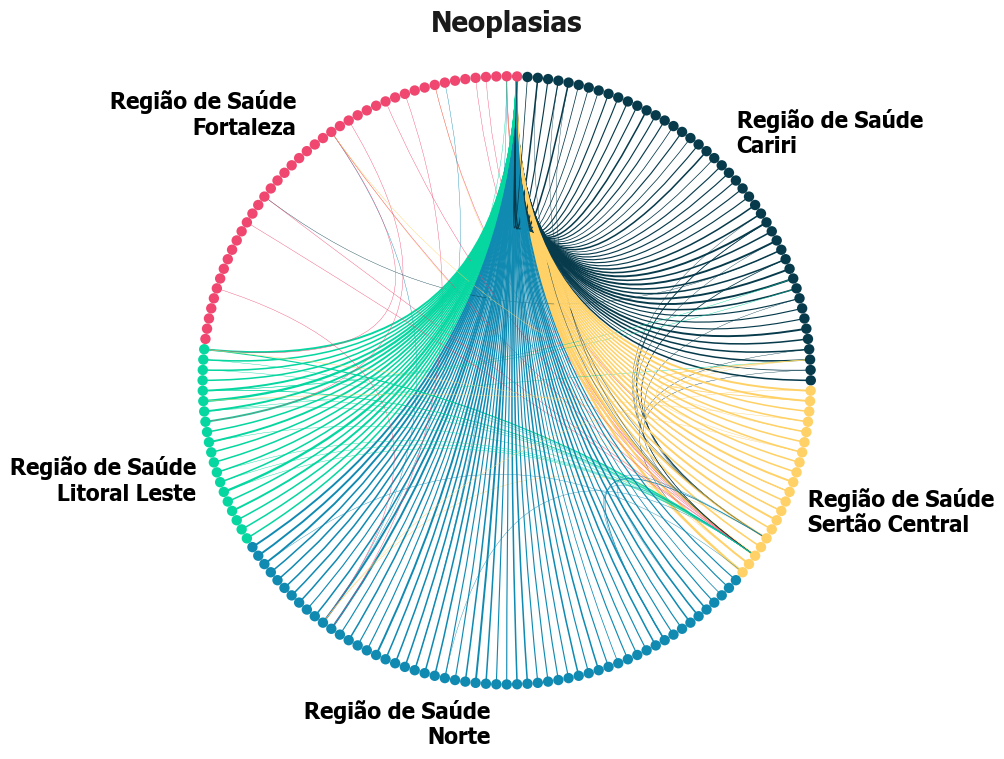

In [86]:
fig_circos, ax_circos = plt.subplots(1, figsize=(10,10))

# -- node styling
pos = layouts.circos(nt, group_by="macro_name", sort_by="macro_name")
annotate.circos_group(G, group_by="macro_name", ax=ax_circos, radius_offset=3, fontdict={'size': 16, 'weight': 'bold' })
node_color = group_colormap_macro(nt["macro_id"])
alpha = nodes.transparency(nt, alpha_by=None)
size = nodes.node_size(nt, size_by=None)
patches = nodes.node_glyphs(
    nt, pos, node_color=node_color, alpha=alpha, size=size
)
for patch in patches:
    ax_circos.add_patch(patch)

# -- edge styling
#edge_color = edges.edge_colors(et, nt=None, color_by=edge_color_hash, node_color_by=None)
edge_color = group_colormap_edges(et["source_macro"])
edge_linewidth = et["edge_log_weight"]
alpha = group_colormap_edges_transparency(et["same_macro"])
patches = lines.circos(
    et, pos, edge_color=edge_color, alpha=alpha, lw=edge_linewidth, aes_kw={"fc": "none"}
)
for patch in patches:
    ax_circos.add_patch(patch)

rescale(G)
aspect_equal()
despine()

ax_circos.set_title(f"{chapter_name[chapter]}", fontsize=20, color="#1a1a1a", weight='bold')
fig_circos.tight_layout()
fig_circos.savefig(netpath.joinpath("figs", f"circos_neoplasia_hrvj_before_jul21_jun23.png"), format="png", dpi=250, bbox_inches="tight")
#fig_circos.savefig(netpath.joinpath("figs", f"circos_neoplasia_hrvj_after_oct23_nov24.png"), format="png", dpi=250, bbox_inches="tight")


Highest exponent (base 10) of flux count: 4.0
Maximum rescaled weight: 125.0
Minimum rescaled weight: 0.0


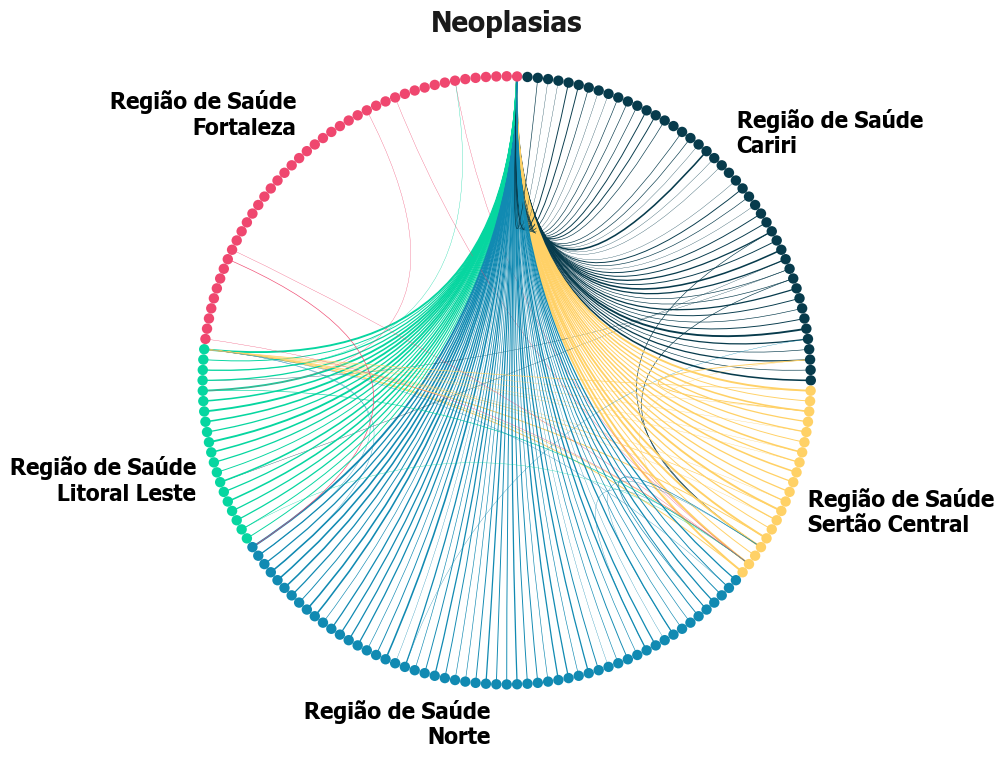

In [87]:
chapter_name = {
    "ch1": "Doenças Infecciosas\ne Parasitárias",
    "ch2": "Neoplasias",
    "ch2_frac": "Neoplasias",
    "ch5": "Transtornos Mentais\ne Comportamentais",
    "ch9": "Doenças do Aparelho\nCirculatório",
    "ch10": "Doenças do Aparelho\nRespiratório",
    "ch19": "Lesões, Envenenamentos\ne Outras Conseqüências de Causas Externas"
}

G = net_neoplasia_hrvj_after
nt = node_table(G)
et1 = edge_table(G)

chapter = "ch2"

# -- logarithm scaling of edge fluxes.
# ---- get the highest exponent of the fluxes in the base 10.
max_power_base10 = np.ceil(np.log10(np.abs(et1[f'{chapter}'].max()))) 
print(f'Highest exponent (base 10) of flux count: {max_power_base10}')
et1['edge_log_weight'] = logrank(et1[f'{chapter}'], max_power_base10, number_of_bins=12)/logrank(et1[f'{chapter}'], max_power_base10, number_of_bins=12).max()

# ---- simple scaling
scaler = 2.5
et1['edge_log_weight'] = et1['edge_log_weight']*scaler
# ---- highlight higher fluxes
et1['edge_log_weight'] = et1['edge_log_weight'].apply(lambda x: x*50.0 if x>(0.7*scaler) else x)


# ---- custom scaling
#et['edge_log_weight'] = et[['edge_log_weight', 'same_ads']].apply(lambda x: x['edge_log_weight']*2 if x['edge_log_weight']>0.50 and x['same_ads']!='-1' else x['edge_log_weight']*0.2, axis=1)

print(f'Maximum rescaled weight: {et1["edge_log_weight"].max()}\nMinimum rescaled weight: {et1["edge_log_weight"].min()}')


fig_circos, ax_circos = plt.subplots(1, figsize=(10,10))

# -- node styling
pos = layouts.circos(nt, group_by="macro_name", sort_by="macro_name")
annotate.circos_group(G, group_by="macro_name", ax=ax_circos, radius_offset=3, fontdict={'size': 16, 'weight': 'bold' })
node_color = group_colormap_macro(nt["macro_id"])
alpha = nodes.transparency(nt, alpha_by=None)
size = nodes.node_size(nt, size_by=None)
patches = nodes.node_glyphs(
    nt, pos, node_color=node_color, alpha=alpha, size=size
)
for patch in patches:
    ax_circos.add_patch(patch)

# -- edge styling
#edge_color = edges.edge_colors(et, nt=None, color_by=edge_color_hash, node_color_by=None)
edge_color = group_colormap_edges(et1["source_macro"])
edge_linewidth = et1["edge_log_weight"]
alpha = group_colormap_edges_transparency(et1["same_macro"])
patches = lines.circos(
    et1, pos, edge_color=edge_color, alpha=alpha, lw=edge_linewidth, aes_kw={"fc": "none"}
)
for patch in patches:
    ax_circos.add_patch(patch)

rescale(G)
aspect_equal()
despine()

ax_circos.set_title(f"{chapter_name[chapter]}", fontsize=20, color="#1a1a1a", weight='bold')
fig_circos.tight_layout()
fig_circos.savefig(netpath.joinpath("figs", f"circos_neoplasia_hrvj_after_oct23_nov24.png"), format="png", dpi=250, bbox_inches="tight")

In [39]:
et1[et1["source_macro"]==4]

SOMA   ch2   ch5   ch19   ch2_frac  source_macro  target_macro  \
329     1.0   0.0   0.0    0.0   0.000000             4             4   
330     1.0   0.0   0.0    1.0   0.000000             4             2   
331     1.0   0.0   0.0    1.0   0.000000             4             4   
332   590.0  95.0   3.0   50.0  17.857143             4             1   
333     4.0   0.0   0.0    0.0   0.000000             4             4   
...     ...   ...   ...    ...        ...           ...           ...   
2162    3.0   0.0   0.0    1.0   0.000000             4             2   
2163   70.0   0.0   0.0    0.0   0.000000             4             4   
2164  430.0  25.0   9.0   78.0  62.500000             4             4   
2165  710.0   0.0   0.0  118.0   0.000000             4             4   
2166  899.0   5.0  15.0   74.0  12.500000             4             4   

      same_macro  source  target  edge_log_weight  
329            4  231290  230260         0.000000  
330           -1  231290  230280         0.000000  
331            4  231290  230410         0.000000  
332           -1  231290  230440         1.090909  
333            4  231290  230470         0.000000  
...          ...     ...     ...              ...  
2162          -1  231360  231140         0.000000  
2163           4  231360  231230         0.000000  
2164           4  231360  231290         0.727273  
2165           4  231360  231340         0.000000  
2166           4  231360  231360         0.363636  

[535 rows x 11 columns]

In [25]:
et

SOMA   ch2   ch5   ch19  source_macro  target_macro  same_macro  \
0       30.0   0.0   0.0    0.0             5             5           5   
1      300.0  65.0   0.0   45.0             5             5           5   
2     1132.0   3.0  13.0  212.0             5             5           5   
3        6.0   0.0   0.0    0.0             5             5           5   
4      482.0  54.0   4.0   13.0             5             1          -1   
...      ...   ...   ...    ...           ...           ...         ...   
3441     1.0   0.0   0.0    0.0             1             1           1   
3442     2.0   0.0   0.0    0.0             1             4          -1   
3443     2.0   0.0   0.0    0.0             1             1           1   
3444   272.0   1.0   0.0    0.0             1             1           1   
3445     1.0   0.0   0.0    0.0             1             1           1   

       ch2_frac  source  target  edge_log_weight  
0      0.000000  230010  230170         0.000000  
1     51.181102  230010  230190         0.444444  
2      2.362205  230010  230250         0.111111  
3      0.000000  230010  230420         0.000000  
4     42.519685  230010  230440         0.444444  
...         ...     ...     ...              ...  
3441   0.000000  231375  231260         0.000000  
3442   0.000000  231375  231290         0.000000  
3443   0.000000  231375  231355         0.000000  
3444   0.900901  231375  231375         0.111111  
3445   0.000000  231375  231380         0.000000  

[3446 rows x 11 columns]

In [26]:
ex = et1['edge_log_weight'] - et['edge_log_weight']

### **Circos - Trauma**

In [66]:
# -- logarithm scaling of edge fluxes.
def logrank(data : pd.Series, max_power_base10 : int, number_of_bins=12):
    logspace = np.logspace(0, max_power_base10, number_of_bins, base=10)
    return data.apply(lambda x: np.argmax(logspace > x)  ) # index of the first true

# -- custom coloring for circos plot
def group_colormap_macro(data : pd.Series):
    cmap = {1: "#ef476f", 2: "#ffd166", 3: "#06d6a0", 4: "#118ab2", 5: "#073b4c"}
    return data.apply(lambda x: cmap.get(x))

def group_colormap_edges(data : pd.Series):
    cmap = {1: "#ef476f", 2: "#ffd166", 3: "#06d6a0", 4: "#118ab2", 5: "#073b4c", -1: "#9c9c9c"}
    return data.apply(lambda x: cmap.get(x))

def group_colormap_edges_transparency(data : pd.Series):
    cmap = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, -1: 1}
    return data.apply(lambda x: cmap.get(x))

def value_colormap(data: pd.Series):
    """Value colormap."""
    norm = plt.cm.Normalize(vmin=data.min(), vmax=data.max())
    cmap = plt.cm.get_cmap("viridis")
    return data.apply(lambda x: cmap(norm(x)))

def node_size(data: pd.Series):
    return data.apply(np.sqrt)

In [67]:
chapter_name = {
    "ch1": "Doenças Infecciosas\ne Parasitárias",
    "ch2": "Neoplasias",
    "ch2_frac": "Neoplasias",
    "ch5": "Transtornos Mentais\ne Comportamentais",
    "ch9": "Doenças do Aparelho\nCirculatório",
    "ch10": "Doenças do Aparelho\nRespiratório",
    "ch19": "Lesões, Envenenamentos\ne Outras Conseqüências de Causas Externas",
    "ch19": "Traumas e Outras Consequências de Causas Externas"
}

G = net_trauma_hrvj_before
nt = node_table(G)
et = edge_table(G)

chapter = "ch19"

# -- logarithm scaling of edge fluxes.
# ---- get the highest exponent of the fluxes in the base 10.
max_power_base10 = np.ceil(np.log10(np.abs(et[f'{chapter}'].max()))) 
print(f'Highest exponent (base 10) of flux count: {max_power_base10}')
et['edge_log_weight'] = logrank(et[f'{chapter}'], max_power_base10, number_of_bins=10)/logrank(et[f'{chapter}'], max_power_base10, number_of_bins=10).max()

# ---- simple scaling
scaler = 1.0
et['edge_log_weight'] = et['edge_log_weight']*scaler
# ---- highlight higher fluxes
et['edge_log_weight'] = et['edge_log_weight'].apply(lambda x: x*50.0 if x>(0.8*scaler) else x)


# ---- custom scaling
#et['edge_log_weight'] = et[['edge_log_weight', 'same_ads']].apply(lambda x: x['edge_log_weight']*2 if x['edge_log_weight']>0.50 and x['same_ads']!='-1' else x['edge_log_weight']*0.2, axis=1)

print(f'Maximum rescaled weight: {et["edge_log_weight"].max()}\nMinimum rescaled weight: {et["edge_log_weight"].min()}')

Highest exponent (base 10) of flux count: 5.0
Maximum rescaled weight: 50.0
Minimum rescaled weight: 0.0


Create plot

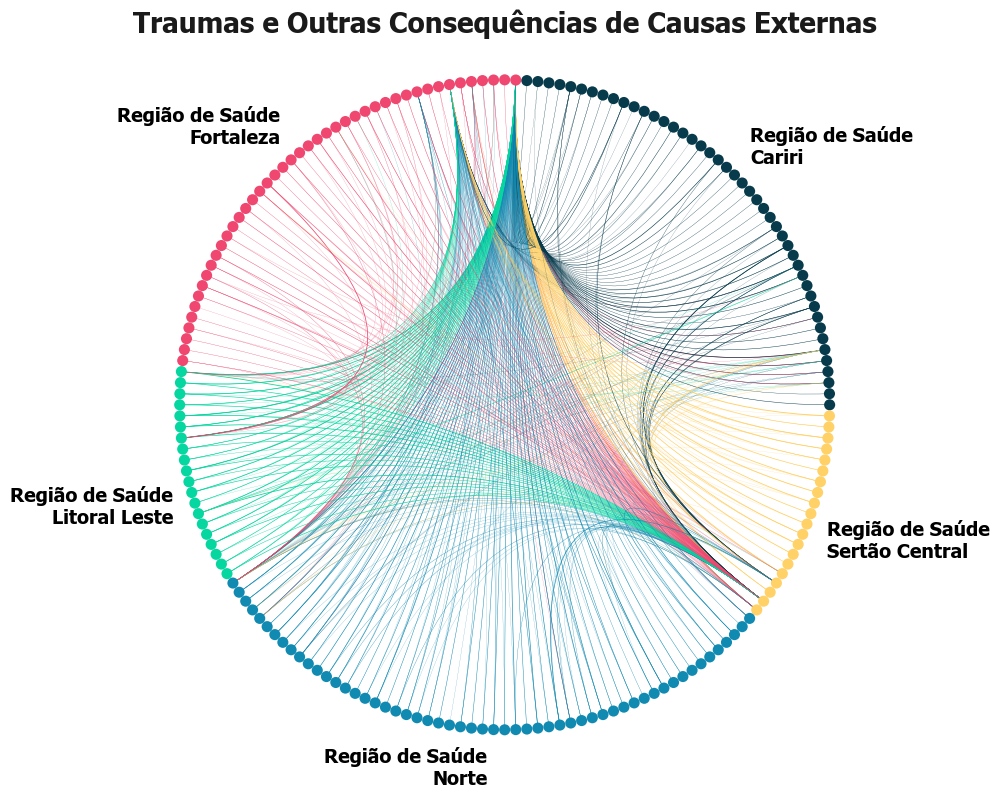

In [71]:
fig_circos, ax_circos = plt.subplots(1, figsize=(10,10))

# -- node styling
pos = layouts.circos(nt, group_by="macro_name", sort_by="macro_name")
annotate.circos_group(G, group_by="macro_name", ax=ax_circos, radius_offset=3, fontdict={'size': 14, 'weight': 'bold' })
node_color = group_colormap_macro(nt["macro_id"])
alpha = nodes.transparency(nt, alpha_by=None)
size = nodes.node_size(nt, size_by=None)
patches = nodes.node_glyphs(
    nt, pos, node_color=node_color, alpha=alpha, size=size
)
for patch in patches:
    ax_circos.add_patch(patch)

# -- edge styling
#edge_color = edges.edge_colors(et, nt=None, color_by=edge_color_hash, node_color_by=None)
edge_color = group_colormap_edges(et["source_macro"])
edge_linewidth = et["edge_log_weight"]
alpha = group_colormap_edges_transparency(et["same_macro"])
patches = lines.circos(
    et, pos, edge_color=edge_color, alpha=alpha, lw=edge_linewidth, aes_kw={"fc": "none"}
)
for patch in patches:
    ax_circos.add_patch(patch)

rescale(G)
aspect_equal()
despine()

ax_circos.set_title(f"{chapter_name[chapter]}", fontsize=20, color="#1a1a1a", weight='bold')
fig_circos.tight_layout()
#fig_circos.savefig(netpath.joinpath("figs", f"circos_neoplasia_hrvj_before_jul21_jun23.png"), format="png", dpi=250, bbox_inches="tight")
#fig_circos.savefig(netpath.joinpath("figs", f"circos_neoplasia_hrvj_after_oct23_nov24.png"), format="png", dpi=250, bbox_inches="tight")
fig_circos.savefig(netpath.joinpath("figs", f"circos_trauma_hrvj_before_jul21_jun23.png"), format="png", dpi=250, bbox_inches="tight")


Highest exponent (base 10) of flux count: 5.0
Maximum rescaled weight: 50.0
Minimum rescaled weight: 0.0


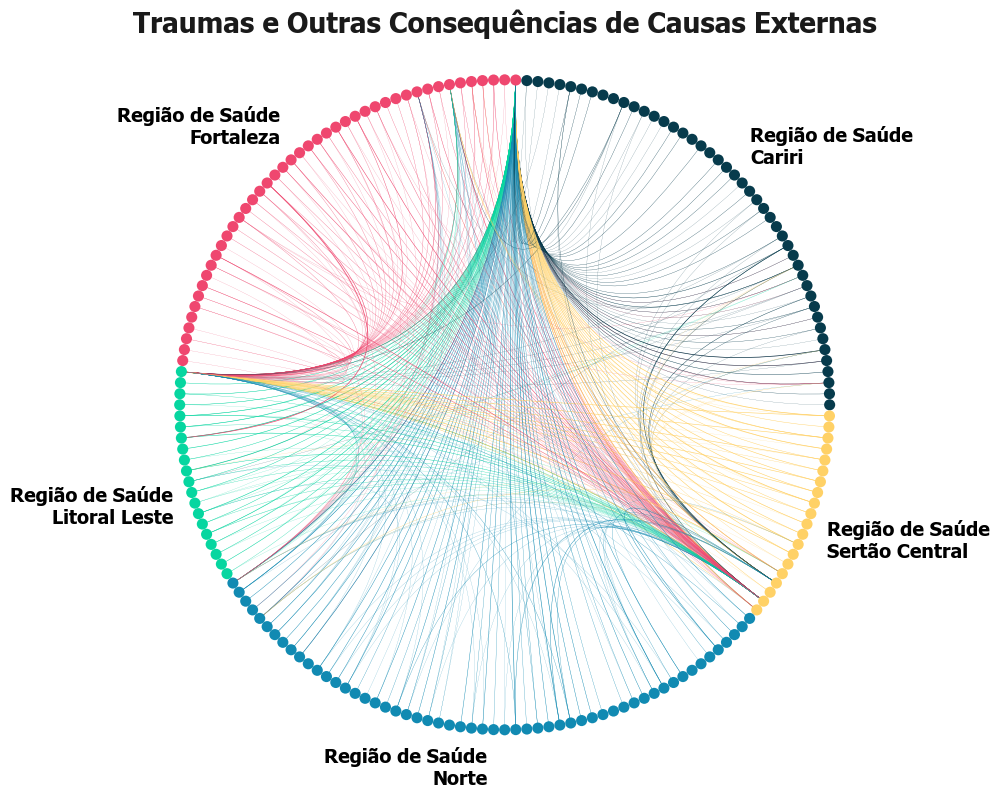

In [70]:
chapter_name = {
    "ch1": "Doenças Infecciosas\ne Parasitárias",
    "ch2": "Neoplasias",
    "ch2_frac": "Neoplasias",
    "ch5": "Transtornos Mentais\ne Comportamentais",
    "ch9": "Doenças do Aparelho\nCirculatório",
    "ch10": "Doenças do Aparelho\nRespiratório",
    "ch19": "Lesões, Envenenamentos\ne Outras Conseqüências de Causas Externas",
    "ch19": "Traumas e Outras Consequências de Causas Externas"
}

G = net_trauma_hrvj_after
nt = node_table(G)
et1 = edge_table(G)

chapter = "ch19"

# -- logarithm scaling of edge fluxes.
# ---- get the highest exponent of the fluxes in the base 10.
max_power_base10 = np.ceil(np.log10(np.abs(et1[f'{chapter}'].max()))) 
print(f'Highest exponent (base 10) of flux count: {max_power_base10}')
et1['edge_log_weight'] = logrank(et1[f'{chapter}'], max_power_base10, number_of_bins=12)/logrank(et1[f'{chapter}'], max_power_base10, number_of_bins=12).max()

# ---- simple scaling
scaler = 1.0
et1['edge_log_weight'] = et1['edge_log_weight']*scaler
# ---- highlight higher fluxes
et1['edge_log_weight'] = et1['edge_log_weight'].apply(lambda x: x*50.0 if x>(0.8*scaler) else x)


# ---- custom scaling
#et['edge_log_weight'] = et[['edge_log_weight', 'same_ads']].apply(lambda x: x['edge_log_weight']*2 if x['edge_log_weight']>0.50 and x['same_ads']!='-1' else x['edge_log_weight']*0.2, axis=1)

print(f'Maximum rescaled weight: {et1["edge_log_weight"].max()}\nMinimum rescaled weight: {et1["edge_log_weight"].min()}')


fig_circos, ax_circos = plt.subplots(1, figsize=(10,10))

# -- node styling
pos = layouts.circos(nt, group_by="macro_name", sort_by="macro_name")
annotate.circos_group(G, group_by="macro_name", ax=ax_circos, radius_offset=3, fontdict={'size': 14, 'weight': 'bold' })
node_color = group_colormap_macro(nt["macro_id"])
alpha = nodes.transparency(nt, alpha_by=None)
size = nodes.node_size(nt, size_by=None)
patches = nodes.node_glyphs(
    nt, pos, node_color=node_color, alpha=alpha, size=size
)
for patch in patches:
    ax_circos.add_patch(patch)

# -- edge styling
#edge_color = edges.edge_colors(et, nt=None, color_by=edge_color_hash, node_color_by=None)
edge_color = group_colormap_edges(et1["source_macro"])
edge_linewidth = et1["edge_log_weight"]
alpha = group_colormap_edges_transparency(et1["same_macro"])
patches = lines.circos(
    et1, pos, edge_color=edge_color, alpha=alpha, lw=edge_linewidth, aes_kw={"fc": "none"}
)
for patch in patches:
    ax_circos.add_patch(patch)

rescale(G)
aspect_equal()
despine()

ax_circos.set_title(f"{chapter_name[chapter]}", fontsize=20, color="#1a1a1a", weight='bold')
fig_circos.tight_layout()
fig_circos.savefig(netpath.joinpath("figs", f"circos_trauma_hrvj_after_oct23_nov24.png"), format="png", dpi=250, bbox_inches="tight")

In [151]:
#230770
#230765
#230100
et[et["source"]=="230100"]

SOMA    ch2   ch5   ch19   ch2_frac  source_macro  target_macro  \
172  1739.0    2.0   0.0   59.0   1.342282             1             1   
173     4.0    0.0   0.0    1.0   0.000000             1             1   
174     1.0    0.0   0.0    0.0   0.000000             1             5   
175     5.0    0.0   0.0    0.0   0.000000             1             2   
176     1.0    0.0   0.0    0.0   0.000000             1             1   
177   220.0    0.0   1.0    2.0   0.000000             1             1   
178  2100.0  143.0  48.0  344.0  95.973154             1             1   
179    20.0    1.0   0.0    0.0   0.671141             1             1   
180     1.0    0.0   0.0    0.0   0.000000             1             5   
181    26.0    3.0   0.0    1.0   2.013423             1             1   
182     6.0    0.0   0.0    3.0   0.000000             1             3   
183     6.0    0.0   0.0    0.0   0.000000             1             1   
184     1.0    0.0   0.0    0.0   0.000000             1             1   
185    15.0    0.0   0.0    0.0   0.000000             1             1   
186     1.0    0.0   0.0    0.0   0.000000             1             2   
187    22.0    0.0   0.0   12.0   0.000000             1             2   
188     2.0    0.0   0.0    0.0   0.000000             1             1   
189     3.0    0.0   0.0    1.0   0.000000             1             4   

     same_macro  source  target  edge_log_weight  
172           1  230100  230100         0.090909  
173           1  230100  230120         0.000000  
174          -1  230100  230130         0.000000  
175          -1  230100  230280         0.000000  
176           1  230100  230370         0.000000  
177           1  230100  230428         0.000000  
178           1  230100  230440         1.250000  
179           1  230100  230523         0.000000  
180          -1  230100  230540         0.000000  
181           1  230100  230625         0.181818  
182          -1  230100  230760         0.000000  
183           1  230100  230765         0.000000  
184           1  230100  230960         0.000000  
185           1  230100  231085         0.000000  
186          -1  230100  231130         0.000000  
187          -1  230100  231140         0.000000  
188           1  230100  231240         0.000000  
189          -1  230100  231290         0.000000

In [144]:
print(count_neo_after_dict['230770'])
for u,v in net_neoplasia_hrvj_after.edges():
    if u=='230770':
        print(v, net_neoplasia_hrvj_after.edges[u,v])

236
230100 {'SOMA': 2.0, 'ch2': 0.0, 'ch5': 0.0, 'ch19': 0.0, 'ch2_frac': 0.0, 'source_macro': 1, 'target_macro': 1, 'same_macro': 1}
230120 {'SOMA': 2.0, 'ch2': 0.0, 'ch5': 0.0, 'ch19': 0.0, 'ch2_frac': 0.0, 'source_macro': 1, 'target_macro': 1, 'same_macro': 1}
230280 {'SOMA': 13.0, 'ch2': 0.0, 'ch5': 0.0, 'ch19': 0.0, 'ch2_frac': 0.0, 'source_macro': 1, 'target_macro': 2, 'same_macro': -1}
230350 {'SOMA': 3.0, 'ch2': 0.0, 'ch5': 0.0, 'ch19': 0.0, 'ch2_frac': 0.0, 'source_macro': 1, 'target_macro': 1, 'same_macro': 1}
230428 {'SOMA': 32.0, 'ch2': 0.0, 'ch5': 0.0, 'ch19': 0.0, 'ch2_frac': 0.0, 'source_macro': 1, 'target_macro': 1, 'same_macro': 1}
230440 {'SOMA': 1994.0, 'ch2': 177.0, 'ch5': 69.0, 'ch19': 249.0, 'ch2_frac': 75.0, 'source_macro': 1, 'target_macro': 1, 'same_macro': 1}
230625 {'SOMA': 1.0, 'ch2': 0.0, 'ch5': 0.0, 'ch19': 0.0, 'ch2_frac': 0.0, 'source_macro': 1, 'target_macro': 1, 'same_macro': 1}
230760 {'SOMA': 6.0, 'ch2': 0.0, 'ch5': 0.0, 'ch19': 3.0, 'ch2_frac': 0.0,

## **Generate edgelist data - C2C**

In [ ]:
output = basepath.joinpath("regulacao", "edgelists", "nordeste_no_service")

## **Load the networks**

c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\pandas\core\frame.py:717: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\pandas\core\frame.py:717: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\pandas\core\frame.py:717: DeprecationWarning: Passing a BlockManager to GeoDataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(


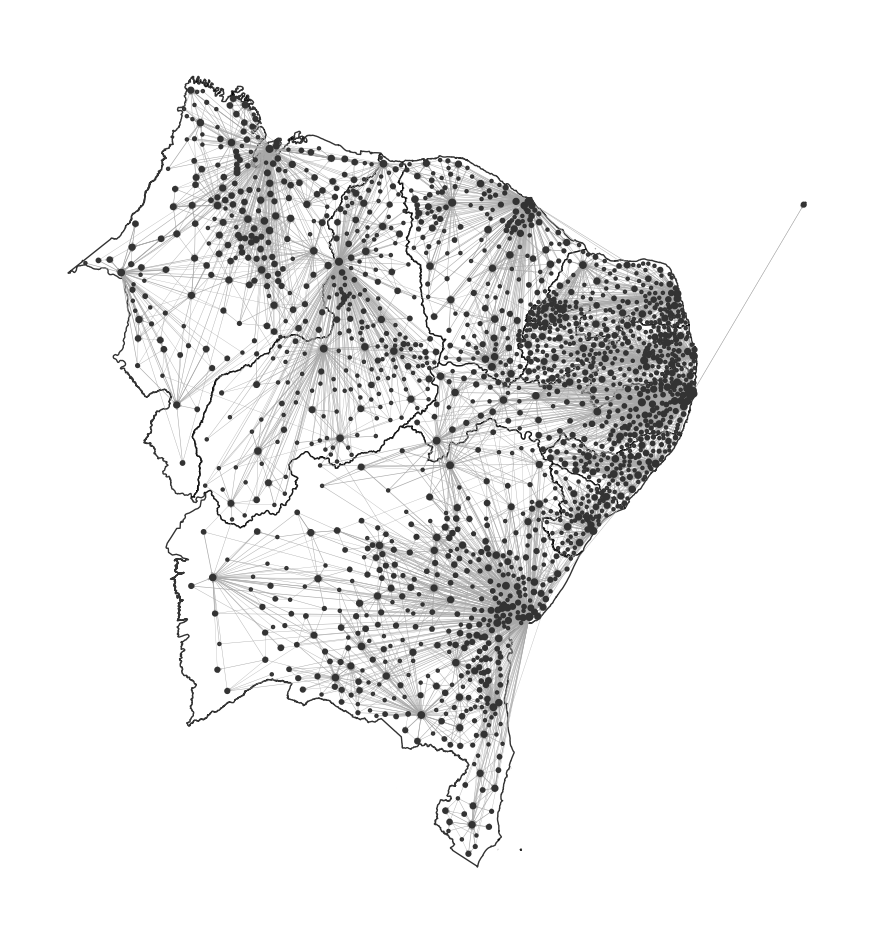

In [ ]:
fig, ax = plt.subplots(1, figsize=(12,12))

# -- brazilian northeast map
ne_map = uf_brasil_df[uf_brasil_df["CD_UF"].isin(['21', '22', '23', '24', '25', '26', '27', '28', '29'])].copy()
ne_map.plot(ax=ax, color="#ffffff00", edgecolor="#000000", linewidth=1.0, alpha=0.8)

feature_map = feature_dict_0
cur_network = feature_map['network'].copy()
# -- remove 'fernando de noronha' for plotting

node_position = feature_map['position_dict']
node_size = feature_map['node_size']
node_size_log = feature_map['node_size_log']
edge_weight = feature_map['edge_weight']

nx.draw(cur_network, pos=node_position, ax=ax, arrows=True, arrowsize=3, node_size=node_size_log, node_color="#333333", edge_color="#a7a7a7", width=weight_edge1["normed"]*0.6, alpha=1.0, linewidths=2)